<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Deep_Learning_project/blob/main/DeepLearning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.2 MB/s eta 0:00:00


In [2]:
!rm -r Deep_Learning_project
!git clone https://github.com/FedericoRaschiatore0123/Deep_Learning_project
%cd Deep_Learning_project
!unzip Arithmetic_extrapolate.zip -d arithmetic_extrapolate
!unzip Arithmetic_interpolate.zip -d arithmetic_interpolate
!unzip Arithmetic.zip -d arithmetic_directory

rm: cannot remove 'Deep_Learning_project': No such file or directory
Cloning into 'Deep_Learning_project'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (17/17), 11.90 MiB | 28.73 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Deep_Learning_project
Archive:  Arithmetic_extrapolate.zip
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__mul_big.txt  
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__add_or_sub_big.txt  
Archive:  Arithmetic_interpolate.zip
  inflating: arithmetic_interpolate/Arithmetic_interpolate/arithmetic__add_or_sub.txt  
  inflating: arithmetic_interpolate/Arithmetic_interpolate/arithmetic__mul.txt  
Archive:  Arithmetic.zip
   creating: arithmetic_directory/Arithmetic/
  inflating: arithmetic_directory/Arithmetic/arithmetic__add_or_sub.txt  

In [3]:
import pytorch_lightning as pl
import os
import random
import re
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence
import matplotlib.pyplot as plt


# Utilities

In [4]:
class Dataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]


class Tokenizer:
    def __init__(self, sentences):
        self.sentences = sentences
        self.vocab = self.crea_vocabolario(sentences)
        self.word_to_id = {word: idx for idx, word in enumerate(self.vocab)}

    def tokenize(self, text):
        txt = re.sub(r"(\d+)", lambda x: " ".join(list(x.group(1))), text)
        tokens = re.findall(r"\b\w+\b|\d+|[^\w\s]", txt)

        token_id = []
        unknown_tokens = []

        new_tokens = []
        for token in tokens:
            flag = 0
            if "." in token and token != ".":
                token = token.split(".")[0]
                flag = 1
            if token in self.word_to_id:
                token_id.append(self.word_to_id[token])
            else:
                token_id.append(self.word_to_id["unknown"])
                unknown_tokens.append(token)
            if flag == 1:
                token_id.append(self.word_to_id["."])

        if unknown_tokens:
            print("Parole sconosciute:", unknown_tokens)

        return token_id

    def crea_vocabolario(self, frasi):
        vocabolario = set()

        for frase in frasi:
            txt = re.sub(r"(\d+)", lambda x: " ".join(list(x.group(1))), frase.lower())
            parole = re.findall(r"\b\w+\b|\d+|[^\w\s]", txt)
            vocabolario.update(parole)
        return ["&", "#", "@", "unknown"] + list(vocabolario)

    def tokenize_q_and_a(self, questions, answers):
        q = []
        a = []
        for x in questions:
            q.append(torch.tensor(self.tokenize(x.lower())))
        for x in answers:
            a.append(torch.tensor(self.tokenize(x.lower())))
        return q, a


def build_dataset(data, q, a, tokenizer):
    q, a = tokenizer.tokenize_q_and_a(q, a)
    q, a = padding(q, a)
    return q, a


def load_dataset(path):
    data = []
    for file in os.listdir(path):
        with open(path + file, "r") as file:
            content = file.read()
            data = data + [x for x in content.split("\n")]
    while "" in data:
        data.remove("")
    len_data = len(data)
    questions = []
    answers = []
    for i in range(len_data):
        if i % 2 == 0:
            questions.append(data[i])
        else:
            dt = data[i] + " @"
            answers.append(dt)
    coppie = list(zip(questions, answers))
    random.shuffle(coppie)
    questions, answers = zip(*coppie)
    return data, questions, answers


def split_dataset(questions, answers):
    l = int(len(questions) / 3)
    train_q = questions[: 2 * l]
    test_q = questions[2 * l :]
    train_a = answers[: 2 * l]
    test_a = answers[2 * l :]
    return train_q, train_a, test_q, test_a


def padding(questions, answers):
    max_length1 = max(len(tensor) for tensor in questions)
    max_length2 = max(len(tensor) for tensor in answers)
    max_length = max(max_length1, max_length2)
    q_padded = pad_sequence(
        [
            torch.cat([tensor, torch.zeros(max_length - len(tensor), dtype=torch.int)])
            for tensor in questions
        ],
        batch_first=True,
    )
    a_padded = pad_sequence(
        [
            torch.cat([tensor, torch.zeros(max_length - len(tensor), dtype=torch.int)])
            for tensor in answers
        ],
        batch_first=True,
    )
    return a_padded, q_padded


def paper_accuracy(predicted_answers, correct_answers):
    num_correct_answers = 0
    end_of_line = 2

    for i in range(len(predicted_answers)):

        single_predicted_answer = torch.argmax(
            predicted_answers[i], 1
        ).tolist()  # vector of shape (answer_max_length) (concatenates the max value for each row)
        index = (
            single_predicted_answer.index(2)
            if 2 in single_predicted_answer
            else len(single_predicted_answer) - 1
        )
        single_predicted_answer = single_predicted_answer[
            0:index
        ]  # removing start and end of line char and additional characters
        single_correct_answer = correct_answers[i].tolist()
        single_correct_answer[-1] = 2
        single_correct_answer = single_correct_answer[
            0 : single_correct_answer.index(2)
        ]  # removing start of line, end of line and following characters

        if single_predicted_answer == single_correct_answer:
            num_correct_answers += 1

    return num_correct_answers / len(predicted_answers)


def translate(phrase, vocab):
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text


def translate_from_output(phrase, vocab):
    phrase = torch.argmax(F.softmax(phrase, dim=-1), dim=-1)
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text


def print_correct(dictionary, batch, res):

    batch_q, batch_a = batch

    for i in range(len(res)):

        index_list = torch.argmax(res[i], 1)  # reverse one_hot
        predicted_string = answer_string = question_string = ""

        for j in range(len(batch_q[i])):
            question_string = question_string + " " + dictionary[batch_q[i][j].item()]

        for j in range(len(index_list)):
            predicted_string = predicted_string + " " + dictionary[index_list[j].item()]

        for j in range(len(batch_a[i])):
            answer_string = answer_string + " " + dictionary[batch_a[i][j].item()]

        print(dictionary)

        print(
            "QUESTION " + question_string + "\n",
            "PREDICTED " + predicted_string + "\n",
            "CORRECT " + answer_string + "\n",
        )


# Dataset preprocessing

In [5]:
path_train = "./arithmetic_directory/Arithmetic/"
path_ext = "./arithmetic_extrapolate/Arithmetic_extrapolate/"
path_inter = "./arithmetic_interpolate/Arithmetic_interpolate/"
batch_size = 64


data, q, a = load_dataset(path_train)
tokenizer = Tokenizer(data)
q_train, a_train, q_test, a_test = split_dataset(q, a)

q_train, a_train = build_dataset(data, q_train, a_train, tokenizer)
train_dataset = Dataset(q_train, a_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

q_test, a_test = build_dataset(data, q_test, a_test, tokenizer)
test_dataset = Dataset(q_test, a_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# data, q, a = load_dataset(path_ext)
# q_ext, a_ext = build_dataset(data, q, a, tokenizer)
# ext_dataset = Dataset(q_ext, a_ext)
# ext_loader = DataLoader(ext_dataset, batch_size=batch_size, shuffle=False)

# data, q, a = load_dataset(path_inter)
# q_inter, a_inter = build_dataset(data, q, a)
# inter_dataset = Dataset(q_inter, a_inter)
# inter_loader = DataLoader(inter_dataset, batch_size=batch_size, shuffle=True)

# LSTM

In [8]:
from torch.nn.modules import dropout
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import random


class LSTM(pl.LightningModule):
    def __init__(self, dict_size, size, dictionary, teacher_forcing_ratio: float = 0.5):
        super().__init__()

        self.hidden_units = 2048
        self.dict_size = dict_size
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.dictionary = dictionary
        self.question_max_length = size
        self.answer_max_length = size
        # Initializing used layers
        self.lstm = nn.LSTM(self.dict_size, self.hidden_units)
        self.linear_layer = nn.Linear(
            self.hidden_units, dict_size, bias=False
        )  # used to return vectors of shape (dict_size)

    def forward(self, batch):
        batch_q, batch_a = batch

        batch_size = len(batch_q)
        batch_questions = batch_q  # shape (batch_size, question_max_length)
        batch_questions = torch.transpose(
            batch_questions, 0, 1
        )  # shape (question_max_length, batch_size)
        batch_questions = F.one_hot(
            batch_questions, self.dict_size
        )  # shape (question_max_length, batch_size, dict_size)
        batch_questions = batch_questions.float().to(device)

        if self.training:
            batch_answers = batch_a  # shape (batch_size, answer_max_length)
            batch_answers = torch.transpose(
                batch_answers, 0, 1
            )  # shape (answer_max_length, batch_size)
            batch_answers = F.one_hot(
                batch_answers, self.dict_size
            )  # shape (answer_max_length, batch_size, dict_size)
            batch_answers = batch_answers.float().to(device)

        # Initializing hidden_state and cell_state used by the lstm cell.
        hidden_state = torch.zeros(
            1, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float
        ).to(
            device
        )  # shape (D*num_layers, batch_size, H_out)
        cell_state = torch.zeros(
            1, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float
        ).to(
            device
        )  # shape (D*num_layers, batch_size, H_cell)

        # Initializing result tensor
        result = torch.empty(self.answer_max_length, batch_size, self.dict_size).to(
            device
        )  # shape (answer_max_length, batch_size, dict_size)

        # input shape (1, batch_size, dict_size)
        # output shape (1, batch_size, hidden_size)
        for i in range(self.question_max_length):
            output, (hidden_state, cell_state) = self.lstm(
                batch_questions[i].unsqueeze(0), (hidden_state, cell_state)
            )

        for i in range(self.answer_max_length):

            result_temp = self.linear_layer(output[0])  # shape (batch_size, dict_size)
            result[i] = result_temp

            if self.training:
                teacher_force = (
                    random.random() < self.teacher_forcing_ratio
                )  # true or false with prob 'teacher_forcing_ratio'

                if teacher_force:  # use correct previous char
                    input = batch_answers[i].unsqueeze(
                        0
                    )  # shape (1, batch_size, dict_size)
                else:  # use previous predicted char
                    input = (
                        F.one_hot(torch.argmax(result_temp, 1), self.dict_size)
                        .unsqueeze(0)
                        .float()
                        .to(device)
                    )  # shape (1, batch_size, dict_size)

            else:
                if i == 0:
                    input = (
                        F.one_hot(torch.tensor([1]), self.dict_size)
                        .repeat(batch_size, 1)
                        .unsqueeze(0)
                        .float()
                        .to(device)
                    )  # shape (1, batch_size, dict_size)
                else:
                    input = (
                        F.one_hot(torch.argmax(result_temp, 1), self.dict_size)
                        .unsqueeze(0)
                        .float()
                        .to(device)
                    )  # shape (1, batch_size, dict_size)

            output, (hidden_state, cell_state) = self.lstm(
                input, (hidden_state, cell_state)
            )  # shape (1, batch_size, hidden_size)
        return torch.transpose(
            (result), 0, 1
        )  # shape (batch_size, answer_max_length, dict_size)

    def training_step(self, batch, _):
        batch_q, batch_a = batch
        # Preparing inputs
        batch_answers = batch_a  # shape (batch_size, answer_max_length)
        batch_answers = batch_answers.flatten(
            0, 1
        )  # shape (batch_size * answer_max_length)

        # Computing prediction and loss

        pred = self(batch).flatten(
            0, 1
        )  # shape (batch_size * answer_max_length, dict_size)
        loss = F.cross_entropy(pred, batch_answers, ignore_index=0)
        losses_lstm.append(loss.detach().cpu().item())

        return loss

    def validation_step(self, batch, _):
        batch_q, batch_a = batch

        pred = self.predict(batch)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)

        self.log("val_tot_accuracy", accuracy)
        return accuracy

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch

        pred = self(batch)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)

        acc_lstm.append(accuracy)
        return accuracy

    def predict(self, questions):
        return self(questions)

    def print_predict(self, questions):
        pred = self.predict(questions.copy())
        return

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), lr=6e-4, betas=(0.9, 0.995), eps=1e-9
        )


# Transformer

In [6]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F


class MultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)

    def forward(self, q, k, v, mask=False):
        q = self.split_heads(self.W_q(q))
        k = self.split_heads(self.W_k(k))
        v = self.split_heads(self.W_v(v))

        att = self.att_score(q, k, v, mask)
        out = self.W_o(self.combine_heads(att))

        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask:
            attn_scores = self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(
            1, 2
        )

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self, tensor):
        mask = torch.triu(
            torch.full(
                (tensor.shape[2], tensor.shape[3]), float("-inf"), device=device
            ),
            diagonal=1,
        )
        tensor = tensor + mask

        return tensor


class EncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x, x, x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))

        return out


class Encoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                EncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(emb_dim, num_heads)

        self.cross_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3


class Decoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                DecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x


class Transformer(pl.LightningModule):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        num_heads=8,
        num_layers=6,
        d_ff=256,
        dropout=0.1,
        teacher_forcing_ratio=0.9,
    ):
        super(Transformer, self).__init__()
        self.d_model = d_model

        self.num_heads = num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size = tgt_vocab_size

        self.transformer_encoder = Encoder(self.d_model, self.num_heads)
        self.transformer_decoder = Decoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)

    def classic_forward(self, batch):
        src, tgt = batch
        max_seq_length = src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat(
            (torch.ones((batch_size, 1), dtype=torch.int).to(device), tgt[:, :-1]),
            dim=1,
        )

        src_embedded = self.dropout(self.src_embedding(src)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        losses_transformer.append(loss.cpu().detach().numpy())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len = batch_a.shape[1]

        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)
        acc_transformer.append(accuracy)
        return accuracy

    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length = x.shape[1]
        src_embedded = self.src_embedding(x).to(device) + self.positional_encoding(
            length, self.d_model
        ).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype=torch.int).to(device)
        out[:, 0] = 1
        output = torch.zeros(batch_dim, length, self.tgt_vocab_size).to(device)
        for i in range(length - 2):
            tgt_embedded = self.tgt_embedding(out) + self.positional_encoding(
                length, self.d_model
            ).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:, i] += self.fc(decode)[:, i]
            prob = F.softmax(output, dim=-1)
            arg_max = torch.argmax(prob, dim=-1)
            out[:, i + 1] = arg_max[:, i]
        return self.classic_forward((x, out))


# TP-Transformer

In [7]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F


class TPAttentionHead(pl.LightningModule):
    def __init__(self, emb_dim, emb_head, dropout=0.0):
        super(TPAttentionHead, self).__init__()

        self.emb_dim = emb_dim
        self.emb_head = emb_head

        self.W_q = nn.Linear(self.emb_dim, self.emb_head)
        self.W_k = nn.Linear(self.emb_dim, self.emb_head)
        self.W_v = nn.Linear(self.emb_dim, self.emb_head)
        self.W_r = nn.Linear(self.emb_dim, self.emb_head)
        self.W_o = nn.Linear(self.emb_head, self.emb_dim)

    def forward(self, q, k, v, r, mask=False):

        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)
        r = self.W_r(r)

        att = self.att_score(q, k, v, mask=mask)  # 62,2,22,22

        return self.W_o(att * r)

    def att_score(self, q, k, v, mask=False):

        attn_scores = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.emb_head)
        if mask:
            attn_scores = self.apply_mask(attn_scores)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def apply_mask(self, tensor):

        mask = torch.triu(
            torch.full(
                (tensor.shape[1], tensor.shape[2]), float("-inf"), device=device
            ),
            diagonal=1,
        )
        tensor = tensor + mask
        return tensor


class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, dropout=0.0):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Layers Initialization
        self.attention_heads = nn.ModuleList(
            [
                TPAttentionHead(self.emb_dim, self.head_dim)
                for _ in range(self.num_heads)
            ]
        )

    def forward(
        self, q, k, v, r, mask=False
    ):  # input shape (batch_size, len_k/len_q/len_v, embedding_size)

        attention_heads_results = []

        for head in self.attention_heads:
            attention_heads_results.append(
                head(q, k, v, r, mask=mask)
            )  # shape (batch_size, len_q, dv)
        concatenated_results = torch.stack(
            attention_heads_results
        )  # shape (batch_size, len_q, num_heads*dv)

        return torch.sum(concatenated_results, dim=0)


class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x, x, x, x)
        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))

        return out


class TPEncoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        self.self_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.cross_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output, out1)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3


class TPDecoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(TPDecoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x

class TPTransformer(pl.LightningModule):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        num_heads=8,
        num_layers=6,
        d_ff=256,
        dropout=0.1,
        teacher_forcing_ratio=0.9,
    ):
        super(TPTransformer, self).__init__()
        self.d_model = d_model

        self.num_heads = num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size = tgt_vocab_size

        self.transformer_encoder = TPEncoder(self.d_model, self.num_heads)
        self.transformer_decoder = TPDecoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)

    def classic_forward(self, batch):
        src, tgt = batch
        max_seq_length = src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat(
            (torch.ones((batch_size, 1), dtype=torch.int).to(device), tgt[:, :-1]),
            dim=1,
        )

        src_embedded = self.dropout(self.src_embedding(src)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        TP_losses.append(loss.cpu().detach().numpy())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len = batch_a.shape[1]

        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(
            pred, batch_a
        )
        TP_acc.append(accuracy)

        return accuracy

    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length = x.shape[1]
        src_embedded = self.src_embedding(x).to(device) + self.positional_encoding(
            length, self.d_model
        ).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype=torch.int).to(device)
        out[:, 0] = 1
        output = torch.zeros(batch_dim, length, self.tgt_vocab_size).to(device)
        for i in range(length - 2):
            tgt_embedded = self.tgt_embedding(out) + self.positional_encoding(
                length, self.d_model
            ).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:, i] += self.fc(decode)[:, i]
            prob = F.softmax(output, dim=-1)
            arg_max = torch.argmax(prob, dim=-1)
            out[:, i + 1] = arg_max[:, i]
        return self.classic_forward((x, out))


# Single M-H Network Transformer

In [54]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F


class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, dropout=0.1):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        self.W_q = nn.Linear(self.emb_dim, self.emb_dim * num_heads)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim * num_heads)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim * num_heads)
        self.W_r = nn.Linear(self.emb_dim, self.emb_dim * num_heads)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)

    def forward(self, q, k, v, r, mask=False):
        q = self.split_heads(self.W_q(q))
        k = self.split_heads(self.W_k(k))
        v = self.split_heads(self.W_v(v))
        r = self.split_heads(self.W_r(r))

        att = self.att_score(q, k, v, mask)
        out = self.W_o(self.combine_heads(att * r))
        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask:
            attn_scores = self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.emb_dim).transpose(
            1, 2
        )

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return torch.sum(x, dim=1)

    def apply_mask(self, tensor):
        mask = torch.triu(
            torch.full(
                (tensor.shape[2], tensor.shape[3]), float("-inf"), device=device
            ),
            diagonal=1,
        )
        tensor = tensor + mask

        return tensor


class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x, x, x, x)
        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))

        return out


class TPEncoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        self.self_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.cross_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output, out1)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3


class TPDecoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(TPDecoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x


class TPTransformer(pl.LightningModule):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        num_heads=8,
        num_layers=6,
        d_ff=256,
        dropout=0.1,
        teacher_forcing_ratio=0.9,
    ):
        super(TPTransformer, self).__init__()
        self.d_model = d_model

        self.num_heads = num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size = tgt_vocab_size

        self.transformer_encoder = TPEncoder(self.d_model, self.num_heads)
        self.transformer_decoder = TPDecoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)

    def classic_forward(self, batch):
        src, tgt = batch
        max_seq_length = src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat(
            (torch.ones((batch_size, 1), dtype=torch.int).to(device), tgt[:, :-1]),
            dim=1,
        )

        src_embedded = self.dropout(self.src_embedding(src)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        TP_losses.append(loss.cpu().detach().numpy())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len = batch_a.shape[1]

        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)

        TP_acc.append(accuracy)

        return accuracy

    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length = x.shape[1]
        src_embedded = self.src_embedding(x).to(device) + self.positional_encoding(
            length, self.d_model
        ).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype=torch.int).to(device)
        out[:, 0] = 1
        output = torch.zeros(batch_dim, length, self.tgt_vocab_size).to(device)
        for i in range(length - 2):
            tgt_embedded = self.tgt_embedding(out) + self.positional_encoding(
                length, self.d_model
            ).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:, i] += self.fc(decode)[:, i]
            prob = F.softmax(output, dim=-1)
            arg_max = torch.argmax(prob, dim=-1)
            out[:, i + 1] = arg_max[:, i]
        return self.classic_forward((x, out))



# Train Model

In this section you can choose and train a model.  
To train a model you need to run the cells containing the model and the following cells:
* Import
* Utilities
* Dataset Preprocessing

## **LSTM**

In [23]:
# Variables Assignment
max_length = q_train.shape[1]
max_length_test = q_test.shape[1]
max_length = max([max_length, max_length_test])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc_lstm = []
losses_lstm = []
print(device)

cuda


In [24]:
# Model Initialization
net = LSTM(len(tokenizer.vocab), max_length, tokenizer.vocab)
net.to(device)

LSTM(
  (lstm): LSTM(46, 2048)
  (linear_layer): Linear(in_features=2048, out_features=46, bias=False)
)

In [43]:
# Train Model
trainer = pl.Trainer(max_epochs=2)
trainer.fit(net, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type   | Params
----------------------------------------
0 | lstm         | LSTM   | 17.2 M
1 | linear_layer | Linear | 94.2 K
----------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.059    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [26]:
#Save Model
model_path = "./model_LSTM.pth"
torch.save(net.state_dict(), model_path)

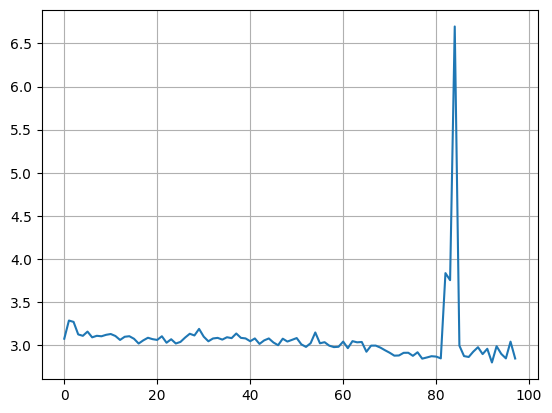

In [46]:
# Plot Losses
lista_losses = [tensor for tensor in losses_lstm]
plt.plot(lista_losses)
plt.grid()
plt.show()


## **Transformer**

In [28]:
# Variables Assignment
torch.cuda.empty_cache()
acc_transformer = []
losses_transformer = []
voc_len = len(tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# Model Initialization
t = Transformer(voc_len, voc_len)
t.to(device)

Transformer(
  (src_embedding): Embedding(46, 512)
  (tgt_embedding): Embedding(46, 512)
  (transformer_encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multihead_attention): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=512, out_features=512, bias=True)
          (W_v): Linear(in_features=512, out_features=512, bias=True)
          (W_o): Linear(in_features=512, out_features=512, bias=True)
        )
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): Decoder(
    (layers): ModuleLis

In [30]:
# Train Model
trainer = pl.Trainer(max_epochs=1)
trainer.fit(t, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 23.6 K
1 | tgt_embedding       | Embedding | 23.6 K
2 | transformer_encoder | Encoder   | 6.5 M 
3 | transformer_decoder | Decoder   | 12.8 M
4 | fc                  | Linear    | 23.6 K
5 | dropout             | Dropout   | 0     
--------------------------------------------------
19.4 M    Trainable params
0         Non-trainable params
19.4 M    Total params
77.650    Total estimated model params size (MB

Training: 0it [00:00, ?it/s]

In [31]:
# Save Model
model_path = "./model_Transformer.pth"
torch.save(t.state_dict(), model_path)

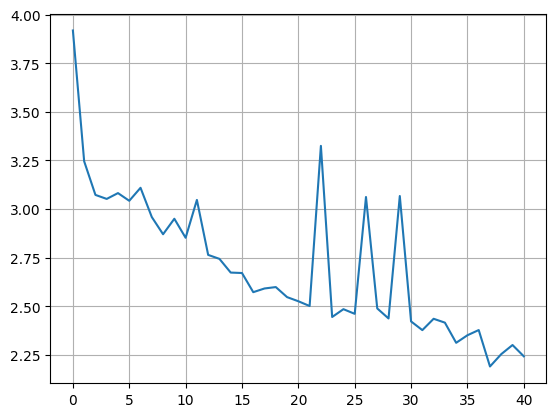

In [32]:
# Plot Losses
plt.plot(losses_transformer)
plt.grid()
plt.show()

## **TP-Transformer**

In [33]:
# Variables Assignment
TP_acc = []
TP_losses = []
TP_voc_len = len(tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Model Initialization
TP_t = TPTransformer(TP_voc_len, TP_voc_len)
TP_t.to(device)

TPTransformer(
  (src_embedding): Embedding(46, 512)
  (tgt_embedding): Embedding(46, 512)
  (transformer_encoder): TPEncoder(
    (layers): ModuleList(
      (0-5): 6 x TPEncoderLayer(
        (multihead_attention): TPMultiHeadAttention(
          (attention_heads): ModuleList(
            (0-7): 8 x TPAttentionHead(
              (W_q): Linear(in_features=512, out_features=64, bias=True)
              (W_k): Linear(in_features=512, out_features=64, bias=True)
              (W_v): Linear(in_features=512, out_features=64, bias=True)
              (W_r): Linear(in_features=512, out_features=64, bias=True)
              (W_o): Linear(in_features=64, out_features=512, bias=True)
            )
          )
        )
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
 

In [38]:
# Train Model
TP_trainer = pl.Trainer(max_epochs=1)
TP_trainer.fit(TP_t, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 23.6 K
1 | tgt_embedding       | Embedding | 23.6 K
2 | transformer_encoder | TPEncoder | 8.1 M 
3 | transformer_decoder | TPDecoder | 16.0 M
4 | fc                  | Linear    | 23.6 K
5 | dropout             | Dropout   | 0     
--------------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.819    Total estimated model params size (MB

Training: 0it [00:00, ?it/s]

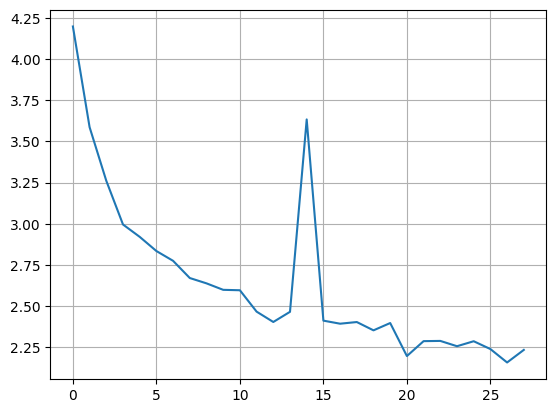

In [36]:
# Plot Losses
plt.plot(TP_losses)
plt.grid()
plt.show()


In [37]:
# Save Model
torch.save(TP_t.state_dict(), 'model_TP_Transformer.pth')

# Test Trained Model
In this section you can download and test a trained model  
To test a model you need to run the cell containg the model and the following cells:
* Import
* Utilities
* Dataset Preprocessing
If not already there you need to load the file with the weights of the model

## **LSTM**

In [39]:
# Variables Assignment
max_length = q_train.shape[1]
max_length_test = q_test.shape[1]
max_length = max([max_length, max_length_test])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc_lstm = []
losses_lstm = []
print(device)

cuda


In [40]:
# Model Initialization
model_path = "./model_LSTM.pth"
net = LSTM(len(tokenizer.vocab), max_length, tokenizer.vocab)
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

LSTM(
  (lstm): LSTM(46, 2048)
  (linear_layer): Linear(in_features=2048, out_features=46, bias=False)
)

In [41]:
# Test Model
trainer = pl.Trainer(max_epochs=1)
trainer.test(net, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [45]:
# Print Accuracy and losses
sum(acc_lstm) / len(acc_lstm)

0.0

## **Transformer**

In [ ]:
# Variables Assignment
torch.cuda.empty_cache()
acc_transformer = []
losses_transformer = []
voc_len = len(tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Model Initialization
t = Transformer(voc_len, voc_len)
t.to(device)
model_path = "./model_Transformer.pth"
t.load_state_dict(torch.load(model_path))

In [ ]:
# Test Model
acc_transformer = []
trainer = pl.Trainer(max_epochs=1)
trainer.test(t, test_loader)

In [ ]:
# Print Accuracy
sum(acc_transformer) / len(acc_transformer)

## **TP-Transformer**

In [ ]:
# Variables Assignment
torch.cuda.empty_cache()
TP_acc = []
TP_losses = []
voc_len = len(tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Model Initialization
TP_t = Transformer(voc_len, voc_len)
TP_t.to(device)
model_path = "./model_TP_Transformer.pth"
TP_t.load_state_dict(torch.load(model_path))

In [ ]:
# Test Model
trainer = pl.Trainer(max_epochs=1)
trainer.test(TP_t, test_loader)

In [ ]:
# Print Accuracy
sum(TP_acc) / len(TP_acc)